We will use a Convolutional Neural Network to classify the roughness exponent, $\zeta$ (zeta), of artificially created interfaces.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [2]:
#Setting a seed for reproducibility
np.random.seed(7)

#dimensions of input image of interface (a square)
length = 128

#amount of images per zeta value
Ninterfaces = 2000

#zetas to test
zetas = np.arange(0.05, 1.05, 0.05)

#proportion of train data to use as validation
test_size = 0.2

#other params
batch_size = 64
num_classes = len(zetas)
epochs = 12

#The following functions generate the interfaces to train and validate.
def generate_interfaces(Ninterfaces, length, zetas, amplitude = 1.0, shuffle = True):
    """
    Generates Ninterfaces of a certain length (integer) for each value of zeta (a float or list of floats) provided.
    Will return numpy arrays with type 'float32'.
    """
    if type(zetas)== float:
        zetas = [zetas]
    #
    q = 2*np.pi/length *( np.arange(Ninterfaces*length/2)%(length/2) + 1 )
    q = q.reshape(Ninterfaces, length//2)
    interfaces = []
    zeta_interfs = []
    for zeta in zetas:
        z_q = np.random.normal(scale=np.sqrt(amplitude*q**(-1-2*zeta))) * np.exp(1j * 2*np.pi*np.random.rand(length//2))
        u_z = np.fft.ifft(z_q, n=length).real
        u_z_quant = np.zeros_like(u_z)
        for interface in range(Ninterfaces):
            u_z_quant[interface] = np.round((u_z[interface] - u_z[interface].mean())*(length//2)) + length//2
            img = np.array([[1.]*length]*length) #1. is max brightness.
            for row in range(length):
                img[row, int(u_z_quant[interface,row]):] = 0.
            interfaces.append(img)
            zeta_interfs.append(zeta)
    if shuffle:
        indices = np.arange(len(interfaces))
        np.random.shuffle(indices)
        interfaces = np.array(interfaces)[indices]
        zeta_interfs = np.array(zeta_interfs)[indices]
    return tuple([interfaces.astype('float32'), zeta_interfs.astype('float32')])

def generate_train_validate_set(Ninterfaces, length, zetas, test_size):
    """
    Generate interfaces and split them into intrfs_train, intrfs_valid, zetas_train, zetas_valid.
    """
    all_train_interfaces, all_train_zetas = generate_interfaces(Ninterfaces, length, zetas)
    return train_test_split(all_train_interfaces, all_train_zetas, test_size=test_size)

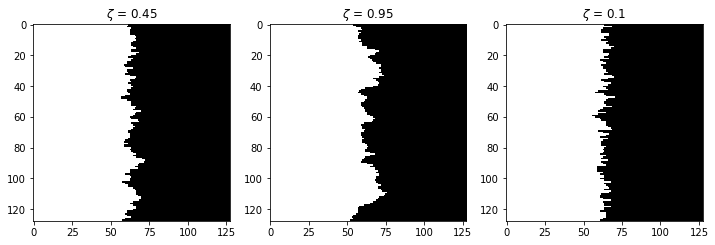

In [3]:
#Sample interfaces:
random_zetas = [.1, .45, .95]
#to obtain a random sample of interfaces use np.random.choice(zetas, 3) instead of list above
interfs_sample, zetas_sample = generate_interfaces(1, length, random_zetas)
fig, axs = plt.subplots(1,3)
fig.set_size_inches(12, 6)
for i in range(len(interfs_sample)):
    axs[i].imshow(interfs_sample[i], cmap='gray')
    axs[i].set_title('$\zeta$ = '+str(zetas_sample[i]))

In [4]:
#Generating train and validate sets
interfs_train, interfs_valid, zetas_train, zetas_valid = generate_train_validate_set(Ninterfaces, length, 
                                                                                     zetas, test_size)
#reshaping data to 'channels_last' format
interfs_train = interfs_train.reshape(interfs_train.shape[0], length, length, 1)
interfs_valid = interfs_valid.reshape(interfs_valid.shape[0], length, length, 1)
input_shape = (length, length, 1)

#zetas_train_temp = zetas_train.copy()
#zetas_valid_temp = zetas_valid.copy()

In [5]:
# convert class vectors to binary class matrices
zetas_train = keras.utils.to_categorical(zetas_train*20-1, num_classes)
zetas_valid = keras.utils.to_categorical(zetas_valid*20-1, num_classes)
#the *20-1 is because .to_categorical() requires array of ints

In [6]:
#Model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='relu'))

model.add(Dense(num_classes, activation='softmax'))



W0726 14:27:15.263329 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0726 14:27:15.601832 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0726 14:27:15.667363 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0726 14:27:15.786193 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0726 1

In [7]:
#Compiling model
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.adam(),
              metrics=['accuracy'])

W0726 14:27:16.891755 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0726 14:27:18.938801 139900556339008 deprecation_wrapper.py:119] From /home/daniel/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [8]:
#Summary of model
model.summary()

#Training and evaluating
model.fit(interfs_train, zetas_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(interfs_valid, zetas_valid))

score = model.evaluate(interfs_valid, zetas_valid, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

W0726 14:27:20.480514 139900556339008 deprecation.py:323] From /home/daniel/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
__________

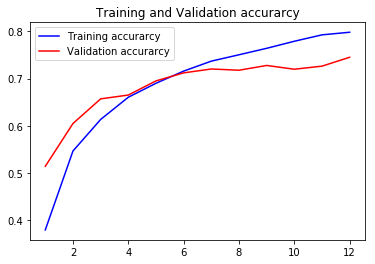

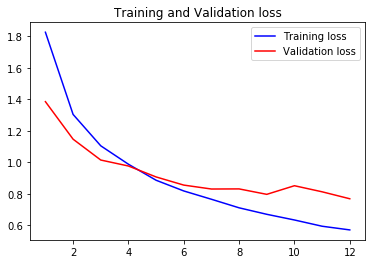

In [9]:
#Plotting the training and validation accuracy curve
history = model.history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs_range, acc, 'b', label='Training accurarcy')
plt.plot(epochs_range, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs_range, loss, 'b', label='Training loss')
plt.plot(epochs_range, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()

In [10]:
#testing with some new interfaces, two per zeta value:
random_zetas = np.random.choice(zetas, 5)
interfs_test, zetas_test = generate_interfaces(2, length, random_zetas)

interfs_test_pred = interfs_test.reshape(10, length, length, 1)

predictions = model.predict(interfs_test_pred)

zetas_pred = []
for i in range(len(interfs_test)):
    zetas_pred.append(np.round(zetas[predictions[i].argmax()],2))
zetas_pred = np.array(zetas_pred)

In [11]:
print(predictions.shape)
print(interfs_test.shape)
print(zetas_pred.shape)
print(zetas_test)

(10, 20)
(10, 128, 128)
(10,)
[0.75 0.15 0.75 0.75 0.05 0.05 0.75 0.05 0.15 0.05]


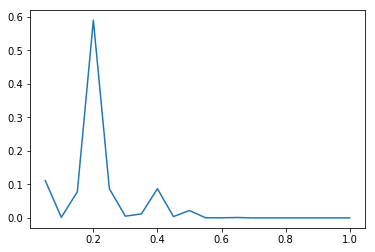

0.05


In [12]:
plt.plot(zetas,predictions[4])
plt.show()
print(zetas_test[4])

Average Error= 0.13500000104308127


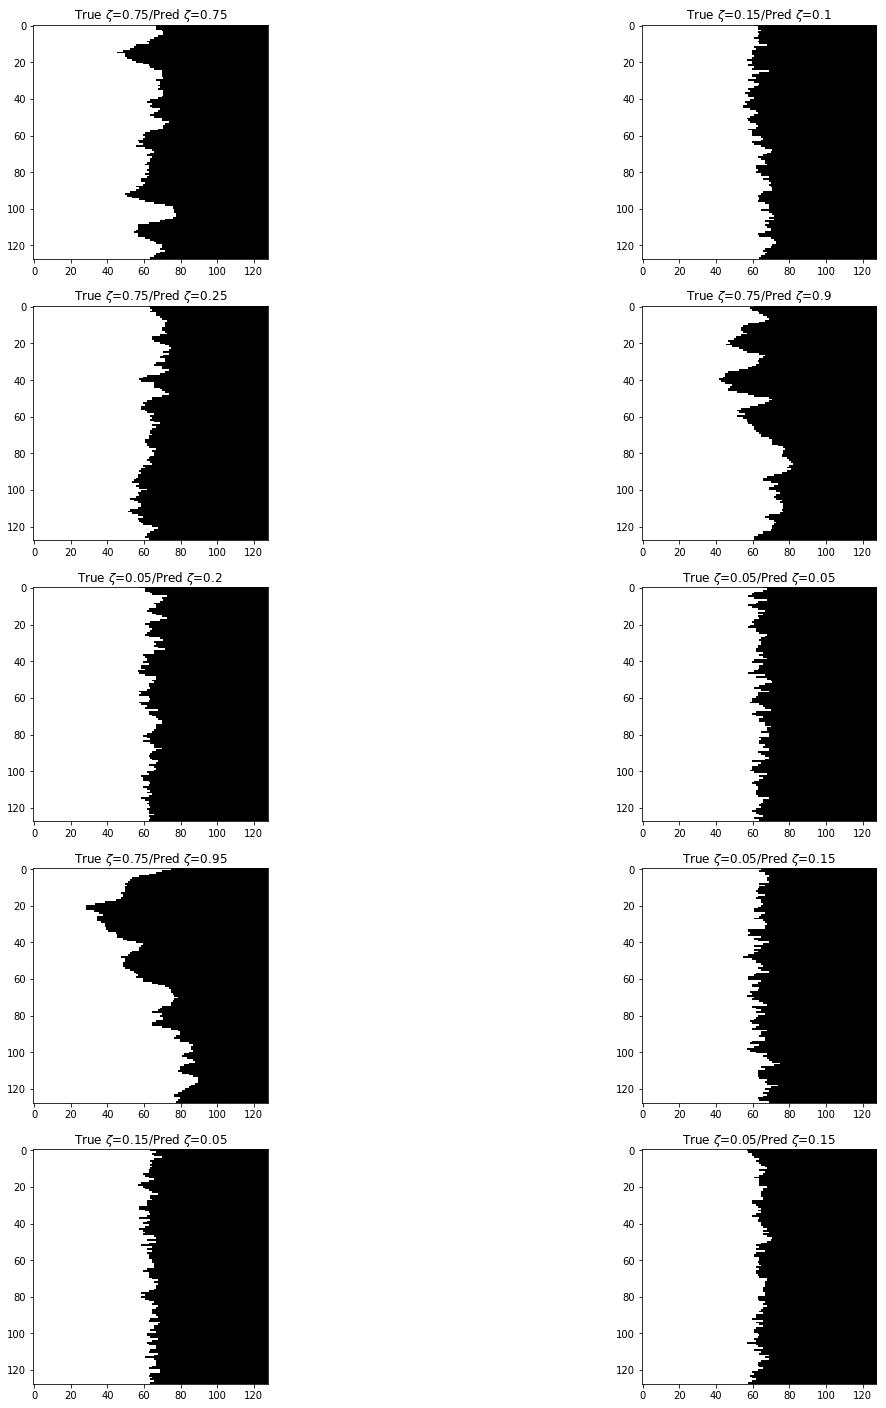

In [13]:
#Plotting test interfaces:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(20,25)
for i in range(len(interfs_test)):
    row = i//2
    col = i%2
    axs[row,col].imshow(interfs_test[i], cmap='gray')
    axs[row,col].set_title('True $\zeta$='+str(zetas_test[i])+'/Pred $\zeta$='+
                    str(zetas_pred[i]))
print('Average Error= '+str(abs(zetas_test - zetas_pred).mean()))

In [14]:
#Save the model
model.save('model_roughnessml.h5')